In [1]:
import epmwebapi as epm
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
import os
credentials = os.environ.get('user_and_password').split(';')
user = credentials[0]
password = credentials[1]

In [3]:
#cria conexao
#para ter acesso ao ECC entre em contato com epm@elipse.com.br
epmConn = epm.EpmConnection('http://ecc.elipse.com.br:44333', 'http://ecc.elipse.com.br:44332', user, password)


iniTime = dt.datetime(2018, 9, 1, 0, 0, 0, 0)
endTime = iniTime + dt.timedelta(days=60)

array_dfs = []

paths = ['ERSF11R4_Temp2', 'ERSF11R4_Temp2SP', 'ERSF11R4_ACCompr2', 'ERSF11R4_ACVent2']

processInterval = dt.timedelta(minutes=5)


#cria objeto queryperiod
queryPeriod = epm.QueryPeriod(iniTime, endTime)

aggInterpDetails = epm.AggregateDetails(processInterval, epm.AggregateType.Interpolative)

for path in paths:
    
    
    bv = epmConn.getDataObjects(path)

    
    result= bv[path].historyReadAggregate(aggInterpDetails, queryPeriod)
    
    #======================================================================================
    # Transformação em DataFrame do pandas
    #======================================================================================
    #corrige o erro: ValueError: Big-endian buffer not supported on little-endian compiler
    new_Quality = result[:]['Quality'].byteswap().newbyteorder()
    new_Timestamp = result[:]['Timestamp']
    new_Value = result[:]['Value'].byteswap().newbyteorder()

    d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
    df_original = pd.DataFrame(d)
    
    #======================================================================================
    # Converte de UTC PARA LOCALTIME
    #======================================================================================
    df_original['Timestamp'] = df_original['Timestamp'].dt.tz_convert('America/Sao_Paulo')
    
    #array de dataframes
    array_dfs.append(df_original)


epmConn.close()

In [4]:
array_dfs[0].shape

(17280, 3)

In [5]:
array_dfs[0].head()

,Value,Timestamp,Quality
0,23.578434,2018-08-31 21:00:00-03:00,0
1,23.566795,2018-08-31 21:05:00-03:00,0
2,23.555159,2018-08-31 21:10:00-03:00,0
3,23.543522,2018-08-31 21:15:00-03:00,0
4,23.531885,2018-08-31 21:20:00-03:00,0


In [6]:
dfs_filtered = []

for df in array_dfs:

    mask = (
        ((df.Timestamp.dt.weekday.between(0,4)) & (df.Timestamp.dt.hour.between(8,11) | (df.Timestamp.dt.hour.between(13,18) )))
        #& (df.Quality == 0)
    )

    df_aux = df.loc[mask]
    dfs_filtered.append(df_aux)

In [7]:
df_01 = dfs_filtered[0][['Timestamp']].copy()
df_01['Temperatura'] = dfs_filtered[0][['Value']].copy()
df_01['TemperaturaSP'] = dfs_filtered[1][['Value']].copy()
df_01['Compressor'] = dfs_filtered[2][['Value']].copy()
df_01['Ventilacao'] = dfs_filtered[3][['Value']].copy()

In [8]:
df_01.shape

(5040, 5)

In [9]:
df_01.dtypes

Timestamp        datetime64[ns, America/Sao_Paulo]
Temperatura                                float32
TemperaturaSP                              float32
Compressor                                 float32
Ventilacao                                 float32
dtype: object

In [10]:
df_01.loc[df_01.Timestamp.dt.hour==12]

,Timestamp,Temperatura,TemperaturaSP,Compressor,Ventilacao


### Análises Iniciais

In [11]:
df_01.describe(include='all')

,Timestamp,Temperatura,TemperaturaSP,Compressor,Ventilacao
count,5040,5040.000000,5040.000000,5040.00000,5040.000000
unique,5040,NaN,NaN,NaN,NaN
top,2018-10-08 18:40:00-03:00,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,24.884628,24.728928,0.16627,0.375794
std,NaN,0.700590,0.692875,0.37236,0.484375
min,NaN,22.191805,21.000000,0.00000,0.000000
25%,NaN,24.385906,24.500000,0.00000,0.000000
50%,NaN,24.841507,25.000000,0.00000,0.000000
75%,NaN,25.394644,25.000000,0.00000,1.000000


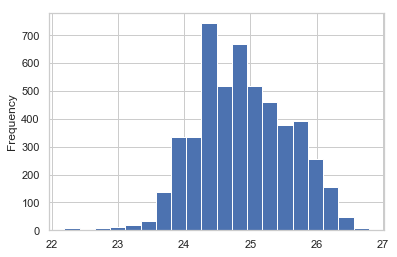

In [12]:
df_01.Temperatura.plot(kind='hist', bins=20)

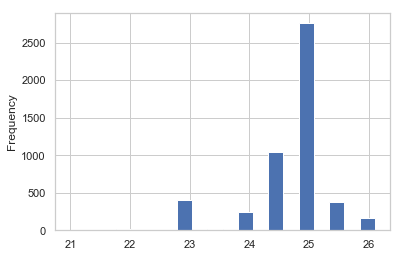

In [13]:
df_01.TemperaturaSP.plot(kind='hist', bins=20)

In [14]:
def conforto(a):
    if a>=24.5 and a<=25.5:
        return 'dentro'
    if a<24.5:
        return 'abaixo'
    else:
        return 'acima'

In [15]:
df_01['conforto_termico'] = df_01.Temperatura.apply(conforto)

In [16]:
df_01.head()

,Timestamp,Temperatura,TemperaturaSP,Compressor,Ventilacao,conforto_termico
708,2018-09-03 08:00:00-03:00,23.792610,25.0,0.0,0.0,abaixo
709,2018-09-03 08:05:00-03:00,23.794382,25.0,0.0,0.0,abaixo
710,2018-09-03 08:10:00-03:00,23.796154,25.0,0.0,0.0,abaixo
711,2018-09-03 08:15:00-03:00,23.797928,25.0,0.0,0.0,abaixo
712,2018-09-03 08:20:00-03:00,23.799700,25.0,0.0,0.0,abaixo


In [17]:
grouped_temp = df_01.groupby(['conforto_termico']).Temperatura.agg(['count', 'max', 'min']).reset_index()
grouped_temp

,conforto_termico,count,max,min
0,abaixo,1665,24.499552,22.191805
1,acima,1104,26.785048,25.500530
2,dentro,2271,25.500000,24.500000


In [18]:
def make_autopct(values):
    #values -> valores enviados
    def my_autopct(pct):
        #pct -> %
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

(-1.25, 1.25, -1.25, 1.25)

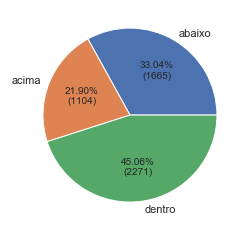

In [22]:
df_01.groupby(['conforto_termico']).Temperatura.count().plot(kind='pie', subplots=True, autopct=make_autopct(grouped_temp['count']))


In [20]:
grouped_comp = df_01.groupby(['Compressor']).Compressor.agg(['count']).reset_index()
grouped_comp

,Compressor,count
0,0.0,4202
1,1.0,838


(-1.25, 1.25, -1.25, 1.25)

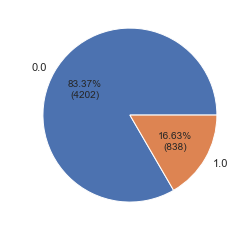

In [21]:
df_01.groupby(['Compressor']).Compressor.count().plot(kind='pie', subplots=True, autopct=make_autopct(grouped_comp['count']))
plt.axis('off')